In [53]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [64]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score

In [2]:

# Folder where your sentiment files are stored
data_dir = r"C:\Users\student\Documents\repo\Task2\data"

# List of dataset filenames
files = ["amazon_cells_labelled.txt", "yelp_labelled.txt", "imdb_labelled.txt"]

# Empty list to store all sentences and labels
sentences = []
labels = []

# Loop through each file and read it
for filename in files:
    file_path = os.path.join(data_dir, filename)
    
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            # Each line has a sentence and a label separated by a tab
            parts = line.strip().split("\t")
            
            # Only process lines that have both a sentence and a label
            if len(parts) == 2:
                sentence, label = parts
                sentences.append(sentence)
                labels.append(int(label))  # convert label string to integer

# Check the first 5 sentences and labels
for i in range(5):
    print(f"{labels[i]} -> {sentences[i]}")


0 -> So there is no way for me to plug it in here in the US unless I go by a converter.
1 -> Good case, Excellent value.
1 -> Great for the jawbone.
0 -> Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!
1 -> The mic is great.


In [3]:
# Combine into a single DataFrame
df = pd.DataFrame({
    "text": sentences,
    "label": labels
})

# Show the first few rows
df.head()

,text,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [4]:
filename = "text_data"
file_path = os.path.join(data_dir, filename)
df.to_csv(file_path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3000 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [6]:
# Combine all text into one big string
all_text = " ".join(df["text"])

# Find characters that are not letters, numbers, or basic punctuation
unusual_chars = set(re.findall(r"[^a-zA-Z0-9\s.,!?'\"]", all_text))
print("Unusual characters found:", unusual_chars)

Unusual characters found: {'/', '&', '*', ')', '-', '\x97', '[', '+', ';', '%', '#', 'é', 'å', ']', '$', '(', ':', '\x96', 'ê'}


In [7]:
# Lowercase and split into words
tokens = re.findall(r"\b\w+\b", all_text.lower())
unique_words = set(tokens)
vocab_size = len(unique_words)

print("Vocabulary size:", vocab_size)
print("Example words:", list(unique_words)[:10])

Vocabulary size: 5183
Example words: ['exceeding', 'casing', 'corded', 'egotism', 'aailiyah', 'spices', 'moments', 'once', 'fries', 'dispenser']


In [8]:
embedding_dim = round(vocab_size ** 0.25)
embedding_dim = round(vocab_size ** 0.25)
print("Chosen embedding length:", embedding_dim)

Chosen embedding length: 8


In [9]:
# Count the number of words in each review
lengths = df["text"].apply(lambda x: len(x.split()))

# Summary statistics
print(lengths.describe())

# Choose a max length that covers 95% of reviews
max_seq_len = int(np.percentile(lengths, 95))
print("Chosen maximum sequence length:", max_seq_len)


count    3000.000000
mean       11.831667
std         7.872441
min         1.000000
25%         6.000000
50%        10.000000
75%        16.000000
max        71.000000
Name: text, dtype: float64
Chosen maximum sequence length: 26


In [10]:
# Combine normalization + tokenization in one step
def tokenize_text(text):
    # Lowercase and keep only words (letters, digits, underscores)
    tokens = re.findall(r"\b\w+\b", text.lower())
    return tokens

# Apply to all reviews
df["tokens"] = df["text"].apply(tokenize_text)

# Show first few examples
for i in range(6):
    print(df.loc[i, "tokens"])

['so', 'there', 'is', 'no', 'way', 'for', 'me', 'to', 'plug', 'it', 'in', 'here', 'in', 'the', 'us', 'unless', 'i', 'go', 'by', 'a', 'converter']
['good', 'case', 'excellent', 'value']
['great', 'for', 'the', 'jawbone']
['tied', 'to', 'charger', 'for', 'conversations', 'lasting', 'more', 'than', '45', 'minutes', 'major', 'problems']
['the', 'mic', 'is', 'great']
['i', 'have', 'to', 'jiggle', 'the', 'plug', 'to', 'get', 'it', 'to', 'line', 'up', 'right', 'to', 'get', 'decent', 'volume']


In [11]:
# Build vocabulary from all tokens
vocab = {"<PAD>": 0}  # 0 will represent padding
index = 1
for tokens in df["tokens"]:
    for word in tokens:
        if word not in vocab:
            vocab[word] = index
            index += 1

# Check vocabulary size
print(vocab)

{'<PAD>': 0, 'so': 1, 'there': 2, 'is': 3, 'no': 4, 'way': 5, 'for': 6, 'me': 7, 'to': 8, 'plug': 9, 'it': 10, 'in': 11, 'here': 12, 'the': 13, 'us': 14, 'unless': 15, 'i': 16, 'go': 17, 'by': 18, 'a': 19, 'converter': 20, 'good': 21, 'case': 22, 'excellent': 23, 'value': 24, 'great': 25, 'jawbone': 26, 'tied': 27, 'charger': 28, 'conversations': 29, 'lasting': 30, 'more': 31, 'than': 32, '45': 33, 'minutes': 34, 'major': 35, 'problems': 36, 'mic': 37, 'have': 38, 'jiggle': 39, 'get': 40, 'line': 41, 'up': 42, 'right': 43, 'decent': 44, 'volume': 45, 'if': 46, 'you': 47, 'several': 48, 'dozen': 49, 'or': 50, 'hundred': 51, 'contacts': 52, 'then': 53, 'imagine': 54, 'fun': 55, 'of': 56, 'sending': 57, 'each': 58, 'them': 59, 'one': 60, 'are': 61, 'razr': 62, 'owner': 63, 'must': 64, 'this': 65, 'needless': 66, 'say': 67, 'wasted': 68, 'my': 69, 'money': 70, 'what': 71, 'waste': 72, 'and': 73, 'time': 74, 'sound': 75, 'quality': 76, 'he': 77, 'was': 78, 'very': 79, 'impressed': 80, 'when

In [12]:
# Encode each review by mapping tokens to their numeric IDs
def encode_tokens(tokens):
    return [vocab[word] for word in tokens if word in vocab]

df["encoded"] = df["tokens"].apply(encode_tokens)

# Check a few encoded sequences
for i in range(3):
    print(df.loc[i, "encoded"])


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 11, 13, 14, 15, 16, 17, 18, 19, 20]
[21, 22, 23, 24]
[25, 6, 13, 26]


In [13]:
#convert the tensors
encoded_tensors = [torch.tensor(seq, dtype=torch.long) for seq in df["encoded"]]


In [14]:
encoded_tensors[0:10]

[tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 11, 13, 14, 15, 16, 17,
         18, 19, 20]),
 tensor([21, 22, 23, 24]),
 tensor([25,  6, 13, 26]),
 tensor([27,  8, 28,  6, 29, 30, 31, 32, 33, 34, 35, 36]),
 tensor([13, 37,  3, 25]),
 tensor([16, 38,  8, 39, 13,  9,  8, 40, 10,  8, 41, 42, 43,  8, 40, 44, 45]),
 tensor([46, 47, 38, 48, 49, 50, 48, 51, 52, 53, 54, 13, 55, 56, 57, 58, 56, 59,
         60, 18, 60]),
 tensor([46, 47, 61, 62, 63, 47, 64, 38, 65]),
 tensor([66,  8, 67, 16, 68, 69, 70]),
 tensor([71, 19, 72, 56, 70, 73, 74])]

In [15]:
# Pad to the maximum length if too short
padded_sequences = pad_sequence(encoded_tensors, batch_first=True, padding_value=0)
# Truncate to the maximum length if any are longer
padded_sequences = padded_sequences[:, :26]

# Check shape and first padded example
print("Padded shape:", padded_sequences.shape)
print("Example padded sequence:\n", padded_sequences[0:6])

Padded shape: torch.Size([3000, 26])
Example padded sequence:
 tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 11, 13, 14, 15, 16, 17,
         18, 19, 20,  0,  0,  0,  0,  0],
        [21, 22, 23, 24,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [25,  6, 13, 26,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [27,  8, 28,  6, 29, 30, 31, 32, 33, 34, 35, 36,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [13, 37,  3, 25,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [16, 38,  8, 39, 13,  9,  8, 40, 10,  8, 41, 42, 43,  8, 40, 44, 45,  0,
          0,  0,  0,  0,  0,  0,  0,  0]])


In [16]:
#number of classes
num_classes = df["label"].nunique()
print("Number of sentiment categories:", num_classes)

Number of sentiment categories: 2


In [38]:
# Convert labels to a torch tensor
labels = torch.tensor(df["label"].values, dtype=torch.float32)

In [39]:
# Step 1. Train / Validation / Test split (80/10/10)
X_train, X_temp, y_train, y_temp = train_test_split(
    padded_sequences, labels, test_size=0.20, random_state=101, stratify=labels
)

#Step 2. Split temp into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=101, stratify=y_temp
)

print(f"Training size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Training size: 2400
Validation size: 300
Test size: 300


In [47]:
# Ensure all input splits are integer (long) tensors for embedding lookup
X_train = torch.tensor(X_train, dtype=torch.long)
X_val   = torch.tensor(X_val, dtype=torch.long)
X_test  = torch.tensor(X_test, dtype=torch.long)

C:\Users\student\AppData\Local\Temp\2\ipykernel_3016\1702955332.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.long)
C:\Users\student\AppData\Local\Temp\2\ipykernel_3016\1702955332.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val   = torch.tensor(X_val, dtype=torch.long)
C:\Users\student\AppData\Local\Temp\2\ipykernel_3016\1702955332.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test  = torch.tensor(X_test, dtype=torch.long)


In [48]:
# Convert padded tensors to Python lists for saving
df["padded_seq"] = padded_sequences.tolist()

# Show first few rows to confirm
df.head()

,text,label,tokens,encoded,padded_seq
0,So there is no way for me to plug it in here i...,0,"[so, there, is, no, way, for, me, to, plug, it...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 11, 13...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 11, 13..."
1,"Good case, Excellent value.",1,"[good, case, excellent, value]","[21, 22, 23, 24]","[21, 22, 23, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,Great for the jawbone.,1,"[great, for, the, jawbone]","[25, 6, 13, 26]","[25, 6, 13, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Tied to charger for conversations lasting more...,0,"[tied, to, charger, for, conversations, lastin...","[27, 8, 28, 6, 29, 30, 31, 32, 33, 34, 35, 36]","[27, 8, 28, 6, 29, 30, 31, 32, 33, 34, 35, 36,..."
4,The mic is great.,1,"[the, mic, is, great]","[13, 37, 3, 25]","[13, 37, 3, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [49]:
filename = "sentiment_data_set"
file_path = os.path.join(data_dir, filename)
df.to_csv(file_path)

In [50]:
class SentimentLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_dim, num_layers=1, dropout=0.3):
        """Initialize the layers of the LSTM sentiment classifier."""
        super(SentimentLSTM, self).__init__()

        # Save parameters for later use
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # 1. Embedding layer: maps words to dense vectors
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # 2. LSTM layer: processes embedded sequences
        # batch_first=True means input shape = (batch, seq_len, features)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )

        # 3. Fully connected output layer: maps hidden features to output
        self.fc = nn.Linear(hidden_dim, output_dim)

        # 4. Sigmoid activation for binary classification (0 = negative, 1 = positive)
        self.activation = nn.Sigmoid()

    def forward(self, input_sequence):
        """Forward pass through the network."""

        # Step 1: Convert token IDs into dense embeddings
        embedded = self.word_embeddings(input_sequence)

        # Step 2: Pass embeddings through the LSTM
        lstm_output, (final_hidden_state, final_cell_state) = self.lstm(embedded)

        # Step 3: Use the final hidden state to represent the entire sequence
        # final_hidden_state has shape [num_layers, batch, hidden_dim]
        last_hidden_layer = final_hidden_state[-1]  # take the last LSTM layer

        # Step 4: Pass through the fully connected layer and sigmoid activation
        output = self.fc(last_hidden_layer)
        return self.activation(output)


In [51]:
vocab_size = len(vocab)
embedding_dim = 8
hidden_dim = 64
output_dim = 1  # Binary output: positive/negative

model = SentimentLSTM(embedding_dim, hidden_dim, vocab_size, output_dim)
print(model)

SentimentLSTM(
  (word_embeddings): Embedding(5184, 8)
  (lstm): LSTM(8, 64, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (activation): Sigmoid()
)


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [52]:
# Example input: one batch of 5 reviews (each length 26)
sample_input = torch.randint(0, vocab_size, (5, 26), dtype=torch.long)

# Forward pass
sample_output = model(sample_input)
print(sample_output.shape)

torch.Size([5, 1])


In [55]:
#print a summary of the model
summary(model, input_size=(5, 26), dtypes=[torch.long])


Layer (type:depth-idx)                   Output Shape              Param #
SentimentLSTM                            [5, 1]                    --
├─Embedding: 1-1                         [5, 26, 8]                41,472
├─LSTM: 1-2                              [5, 26, 64]               18,944
├─Linear: 1-3                            [5, 1]                    65
├─Sigmoid: 1-4                           [5, 1]                    --
Total params: 60,481
Trainable params: 60,481
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.67
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.24
Estimated Total Size (MB): 0.32

In [57]:
# Create TensorDatasets
train_data = TensorDataset(X_train, y_train)
val_data   = TensorDataset(X_val, y_val)
test_data  = TensorDataset(X_test, y_test)

# Create DataLoaders
batch_size = 32  # standard for NLP

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader   = DataLoader(val_data, batch_size=batch_size)
test_loader  = DataLoader(test_data, batch_size=batch_size)


In [60]:
# Binary classification → Binary Cross-Entropy Loss
criterion = nn.BCELoss()

# Adam optimizer — stable and fast for NLP
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [67]:
num_epochs = 10
patience = 2  # stop if no improvement after 2 epochs
best_val_loss = float("inf")
wait = 0
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # ---- TRAINING PHASE ----
    model.train()
    train_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()  # remove extra dimension
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # ---- VALIDATION PHASE ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # ---- EPOCH RESULTS ----
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # ---- EARLY STOPPING ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

# Restore best model
model.load_state_dict(best_model_state)

Epoch 1/10 | Train Loss: 0.5870 | Val Loss: 0.6363
Epoch 2/10 | Train Loss: 0.5632 | Val Loss: 0.6046
Epoch 3/10 | Train Loss: 0.5450 | Val Loss: 0.6030
Epoch 4/10 | Train Loss: 0.5149 | Val Loss: 0.6060
Epoch 5/10 | Train Loss: 0.4888 | Val Loss: 0.5913
Epoch 6/10 | Train Loss: 0.4700 | Val Loss: 0.6086
Epoch 7/10 | Train Loss: 0.4402 | Val Loss: 0.5961
Early stopping triggered.


<All keys matched successfully>

In [63]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()
        preds = (outputs > 0.5).float()  # convert probabilities to 0/1
        y_true.extend(labels.numpy())
        y_pred.extend(preds.numpy())

# Calculate metrics
test_acc = accuracy_score(y_true, y_pred)
test_f1  = f1_score(y_true, y_pred)

print(f"Test Accuracy: {test_acc:.3f}")
print(f"Test F1 Score: {test_f1:.3f}")


Test Accuracy: 0.677
Test F1 Score: 0.676


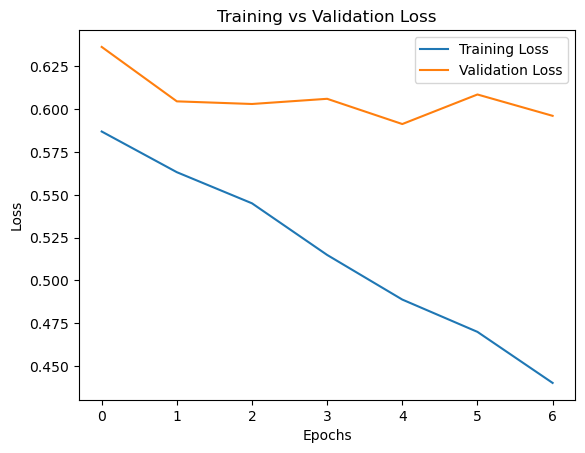

In [70]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

In [72]:
# Save the trained model’s state dictionary
torch.save(model.state_dict(), "sentiment_lstm_model.pth")